# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scripts.preprocessing import data_preprocessing, principal_components

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
# load in the data
azdias = pd.read_csv('../files/Udacity_AZDIAS_052018.csv', sep=';', dtype='object')
customers = pd.read_csv('../files/Udacity_CUSTOMERS_052018.csv', sep=';', dtype='object')

In [4]:
# Preprocess data
azdias_prep = data_preprocessing(azdias)
customers_prep = data_preprocessing(customers)

# Get Principal Components 

azdias_df, azdias_pca = principal_components(azdias_prep)
customer_df, customer_pca = principal_components(customers_prep)

Old Dataframe Shape: (891221, 366)

Succesfully removed 61 columns!
BIP_FLAG was not found in the DF
CAMEO_DEUINTL_2015 was not found in the DF
D19_KK_KUNDENTYP was not found in the DF
GEOSCORE_KLS7 was not found in the DF
GEOSCORE_KLS7 was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
KBA13_CCM_1400_2500 was not found in the DF
OST_WEST_KZ was not found in the DF
SOHO_FLAG was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
The columns below threshold: ['TITEL_KZ'] were removed.
Old Dataframe Shape: (191652, 369)

Succesfully removed 64 columns!
BIP_FLAG was not found in the DF
CAMEO_DEUINTL_2015 was not found in the DF
D19_KK_KUNDENTYP was not found in the DF
GEOSCORE_KLS7 was not found in the DF
GEOSCORE_KLS7 was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
KBA13_CCM_1400_2500 was not found in the DF
OST_WEST_K

## Clustering with KMeans

In [14]:
from sklearn.cluster import KMeans

tot_components = azdias_df.shape[1]
n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=range(1,10), \
                              columns=['inertia'])
for n_clusters in range(1,10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = tot_components-1
    kmeans.fit(azdias_df.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

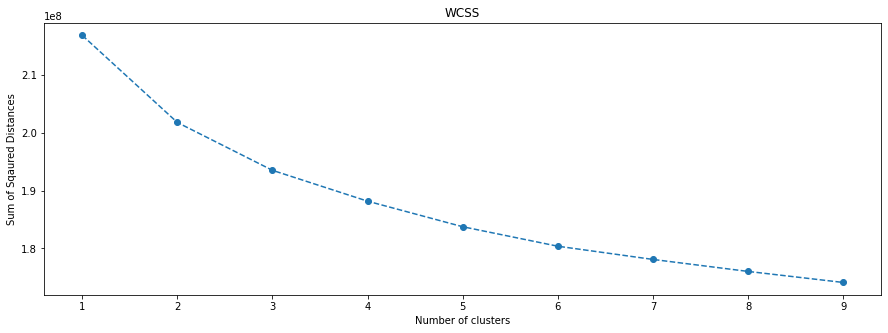

In [16]:
plt.figure(figsize=(15,5))
plt.plot(kMeans_inertia,marker='o',linestyle='--')
plt.title("WCSS")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Sqaured Distances")
plt.show()

In [17]:
# The right amount of clusters is 7. Starting from that point there no significante improvement.

for i in range(kMeans_inertia.shape[0]-1):
    print("WCSS difference between cluster {} and {}: {}%".\
          format(i+1,i+2,
                 round((kMeans_inertia.iloc[i,0] - kMeans_inertia.iloc[i+1,0])/kMeans_inertia.iloc[i,0]*100,2)) )

WCSS difference between cluster 1 and 2: 6.94%
WCSS difference between cluster 2 and 3: 4.1%
WCSS difference between cluster 3 and 4: 2.76%
WCSS difference between cluster 4 and 5: 2.35%
WCSS difference between cluster 5 and 6: 1.83%
WCSS difference between cluster 6 and 7: 1.26%
WCSS difference between cluster 7 and 8: 1.16%
WCSS difference between cluster 8 and 9: 1.08%


In [18]:
def kmeans_clustering(n_clusters, base_df, predict_df):
    '''
        Get the clusters for the dataframe
        input:
            n_clusters - Number of clusters
            base_df - Base df for generating model
            predict_dt - Dataframe to predict with model
        output:
            base_pred - Predicted values for base df
            predict_df - Predicted values for target df
    '''
    n_clusters = n_clusters
    n_init = 10
    max_iter = 300
    tol = 0.0001
    random_state = 2018

    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                    max_iter=max_iter, tol=tol, random_state=random_state)
    cutoff = tot_components-1
    model = kmeans.fit(base_df.loc[:,0:cutoff])
    
    # Predict values
    base_pred =  model.predict(base_df)
    predict_df = model.predict(predict_df)
    
    return base_pred, predict_df, model

In [20]:
# Get predictions for azdias and customers

azdias_kmeans, customers_kmeans, model = kmeans_clustering(7, azdias_df, customer_df)

## Compare Clusters

In [34]:
df_comparison = (pd.Series(azdias_kmeans).value_counts()/azdias_kmeans.shape[0]*100)\
    .to_frame(name="Population (%)").reset_index().rename(columns={'index':'Cluster'}).\
    merge(
    (pd.Series(customers_kmeans).value_counts()/customers_kmeans.shape[0]*100)\
    .to_frame(name="Customers (%)").reset_index().rename(columns={'index':'Cluster'}), on=['Cluster'])
df_comparison["Difference"] = (df_comparison['Population (%)']-df_comparison['Customers (%)'])
df_comparison.sort_values(by='Difference', ascending=False)

,Cluster,Population (%),Customers (%),Difference
4,4,10.990316,2.490973,8.499342
2,2,16.062122,10.850396,5.211726
0,5,18.189316,16.037401,2.151914
6,0,10.537117,8.791455,1.745662
5,1,10.735497,12.214326,-1.478829
1,6,17.877721,20.041012,-2.163291
3,3,15.607913,29.574437,-13.966524
